In [1]:
import numpy as np
import pandas as pd
import torch
import requests
import json
import time
from google.colab import userdata
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# download the data from github

!git clone https://github.com/zengwesley31729/MTK_TA.git


fatal: destination path 'MTK_TA' already exists and is not an empty directory.


In [3]:
!pip install -q tiktoken datasets
!pip install --upgrade --quiet  langchain langchain-community langchainhub langchain-openai langchain-chroma bs4
!pip install sentence_transformers

In [6]:
import datasets
from datasets import load_dataset
from sentence_transformers import util

In [28]:
# https://arxiv.org/abs/2309.08448
dataset = load_dataset("MediaTek-Research/TCEval-v2", 'drcd')

In [7]:
#show the test and dev set in this dataset
# we will only use the test part because dev only have 5 samples
dataset

DatasetDict({
    test: Dataset({
        features: ['id', 'paragraph', 'question', 'references'],
        num_rows: 3493
    })
    dev: Dataset({
        features: ['id', 'paragraph', 'question', 'references'],
        num_rows: 5
    })
})

In [29]:
data = dataset['test'].to_pandas()
train= data[:1000].copy(deep=True).reset_index(drop=True)# use first 1000 sample as training set
test= data[1000:1200].copy(deep=True).reset_index(drop=True) # 1000-1200 samples as test set
noise= data[1300:2300].copy(deep=True).reset_index(drop=True) # 1300-2300 samples as noise set

# In the later model training we need positive sample (question with correct paragraph pairs)
# negative sample (question with wrong paragraph pair)
print("train:",len(train))
print(len(test))
print(len(noise))
train.head()

train: 1000
200
1000


,id,paragraph,question,references
0,test-0,要探討從梨俱吠陀到波你尼時代梵語的發展，可以考察印度教其它文本，如娑摩吠陀、夜柔吠陀、阿闥婆...,夜柔吠陀與阿闥婆吠陀均可以最為研究哪一門語言的參考？,[梵語]
1,test-1,要探討從梨俱吠陀到波你尼時代梵語的發展，可以考察印度教其它文本，如娑摩吠陀、夜柔吠陀、阿闥婆...,哪一本書規範了梵語的正確語法？,"[八篇書, 《八篇書》]"
2,test-2,要探討從梨俱吠陀到波你尼時代梵語的發展，可以考察印度教其它文本，如娑摩吠陀、夜柔吠陀、阿闥婆...,中古印度-雅利安語方言的前身與哪一門語言都同時在古印度使用？,[梵語]
3,test-3,波你尼所定義的梵語是從更早的「吠陀」形式演化出來的。學者經常把吠陀梵語和古典或「波你尼」梵語...,波你尼梵語與哪一門語言非常相似？,[吠陀梵語]
4,test-4,波你尼所定義的梵語是從更早的「吠陀」形式演化出來的。學者經常把吠陀梵語和古典或「波你尼」梵語...,印度教的最早宗教文本以什麼語言撰寫？,[吠陀梵語]


In [9]:
#build negative sample dataset
question=train['question'] # we use the question in training set
noise_context=noise['paragraph'] # use the paragraph in noise set
noise_label=[]
for i in range(len(noise)):
  noise_label.append(0) # Wrong pairs labels are 0
neg_dataframe=pd.DataFrame({'question':question, 'context':noise_context, 'label':noise_label})

In [13]:
neg_dataframe.tail(n=5)

,question,context,label
995,在參與第四次十字軍東征中，誰收益最豐厚?,根據日本放送協會於2009年9月及南韓國家安全戰略研究所所長南成旭在10月21日時透露，金正...,0
996,1204年3月，丹都洛總督和十字軍的統帥們決議選出選舉團來選出一個拉丁皇帝，選舉團由誰構成?,根據日本放送協會於2009年9月及南韓國家安全戰略研究所所長南成旭在10月21日時透露，金正...,0
997,經過選舉後由鮑德溫伯爵獲選拉丁皇帝，他管理的區域被稱為?,根據日本放送協會於2009年9月及南韓國家安全戰略研究所所長南成旭在10月21日時透露，金正...,0
998,在會議中，決議將東羅馬帝國的1/4給拉丁皇帝，剩下的由威尼斯人和誰取走?,根據日本放送協會於2009年9月及南韓國家安全戰略研究所所長南成旭在10月21日時透露，金正...,0
999,威尼斯的右眼是指伯羅奔尼撒半島南端的摩冬港和哪個港口?,朝鮮人民軍最高司令官金正日於2010年9月27日下達第0051號命令，任命金正恩為朝鮮人民軍...,0


In [15]:
#build positive sample dataset
question=train['question'] # training set question
context=train['paragraph'] # training set paragraph
label=[]
for i in range(len(train)):
  label.append(1) # Correct pairs labels are 1
pos_dataframe=pd.DataFrame({'question':question, 'context':context, 'label':label})
qc_all = pd.concat([pos_dataframe, neg_dataframe], axis=0, ignore_index=True) #concate positive and negative sample dataset
qc_all = qc_all.sample(frac=1).reset_index(drop=True) #shuffle the dataframe
pos_dataframe['references']=train['references']

In [30]:
#In original drcd dataset, one paragraph can have multiple questions, we only choose the first one question for example
train = train[train['references'].apply(len)==1]
test = test[test['references'].apply(len)==1]
train['references'] = train['references'].apply(lambda x: x[0])
test['references'] = test['references'].apply(lambda x: x[0])

<ipython-input-30-109a9ec4ff16>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['references'] = train['references'].apply(lambda x: x[0])
<ipython-input-30-109a9ec4ff16>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['references'] = test['references'].apply(lambda x: x[0])


##Row text should go through the tokenizer to encode into token

*   tiktoken is a fast BPE tokeniser for use with OpenAI's models.
*   OpenAi embedding already have tokenizer method inside. This is an example to demostrate how tokenizer worked.


In [ ]:
import tiktoken # tiktoken is a fast BPE tokeniser for use with OpenAI's models.
enc = tiktoken.encoding_for_model("gpt-4o") # Use gpt-4o voclbulary table

In [ ]:
print('encode',enc.encode("你好"))
print('decode',enc.decode([177519]))

encode [177519]
decode 你好


In [ ]:
token_count=0
for i in range(len(train)):
  token = enc.encode(train.iloc[i]['context'])
  token_count+=len(token)
print('total token', token_count)
print('train set length',len(train.context))
avg=token_count/len(train.context)
print('average token length', avg)

total token 308697
train set length 800
average token length 385.87125


## Langchain RAG Data preprocessing
https://python.langchain.com/v0.2/docs/tutorials/rag/

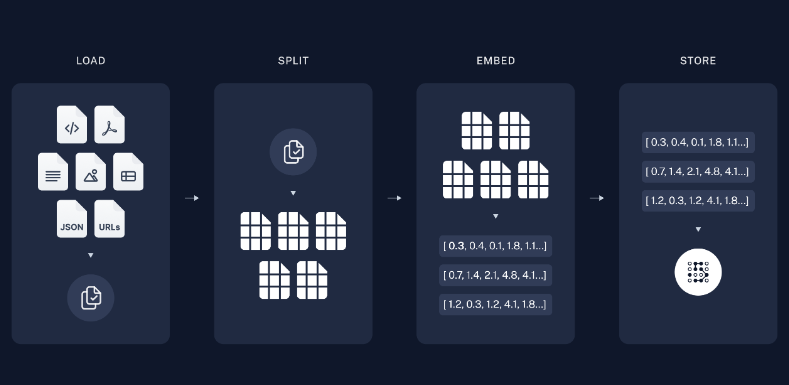

In [16]:
from langchain_openai import AzureOpenAIEmbeddings


embeddings = AzureOpenAIEmbeddings(deployment="text-embedding-ada-002",
                               openai_api_key=userdata.get('mtk'),
                               azure_endpoint='https://mtknycuragwebinar.openai.azure.com/',
                               openai_api_version='2024-05-01-preview',
                               max_retries=10,
                               chunk_size=400,
                               show_progress_bar=True)

In [141]:
docs = []
from langchain.docstore.document import Document
for _, record in train.iterrows():
    docs.append(Document(page_content=record['paragraph'], metadata={"id": record['id']}))

In [ ]:
from langchain_chroma import Chroma
Chroma().delete_collection()
vectorstore = Chroma.from_documents(documents=docs, embedding=embeddings)
print(len(vectorstore.get()['documents']))

  0%|          | 0/2 [00:00<?, ?it/s]

In [34]:
results = []
from tqdm.notebook import tqdm
for _, record in tqdm(test.iterrows(), total=len(test)):
  q = record['question']
  results.append(vectorstore.similarity_search_with_score(q, k=5))

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

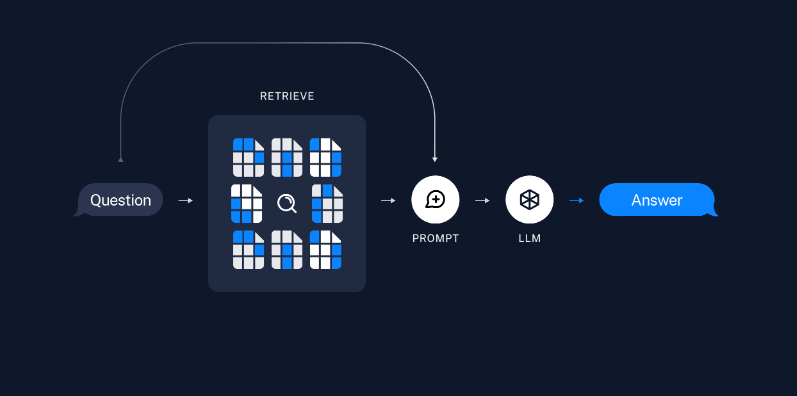

In [139]:
def rag_ask(question, topk):
    data = {
    "input": question
    }
    endpoint = "https://mtknycuragwebinar.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-05-01-preview"
    api_key = userdata.get('mtk')
    headers = {
    "Content-Type": "application/json",
    "api-key": api_key
    }
    query_template = """請根據給定的文件回答問題,如果無法回答請回覆"超出可回答文件範圍"
        文件:
        \"\"\"
        {}
        \"\"\"
        問題: {}"""
    doc=vectorstore.similarity_search_with_score(question, k=topk)
    template = query_template.format(str(doc), question)
    data = {
    "messages": [
        {"role": "system", "content": "請根據給定的文件回答問題"},
        {"role": "user", "content": template}
    ],
    "max_tokens": 100,
    "temperature": 0.0
      }

    response = requests.post(endpoint, headers=headers, data=json.dumps(data))

    # 檢查請求是否成功
    if response.status_code == 200:
      response_data = response.json()
      print("問題", question)
      print("回應：", response_data["choices"][0]["message"]["content"])
    else:
      print("請求失敗，狀態碼：", response.status_code)
      print("錯誤訊息：", response.text)

In [140]:
text="夜柔吠陀與阿闥婆吠陀均可以最為研究哪一門語言的參考？"
topk=5
rag_ask(text, topk)

  0%|          | 0/1 [00:00<?, ?it/s]

問題 夜柔吠陀與阿闥婆吠陀均可以最為研究哪一門語言的參考？
回應： 超出可回答文件範圍


## Hit rate calculation
Hit rate measures the retrived document contain the ground truth document or not

In [136]:
test=pd.read_csv("/content/MTK_TA/test.csv")
original_q = torch.load("/content/MTK_TA/test_question_embedding_ada.pt")
original_c = torch.load("/content/MTK_TA/test_context_embedding_ada.pt")
print(len(test))
print(original_q.shape)
print(original_c.shape)

original_q = original_q.squeeze(1)
original_c = original_c.squeeze(1)

162
torch.Size([162, 1536])
torch.Size([162, 1536])


In [137]:
from sentence_transformers import util
# Query sentences:
# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5
# Alternatively, we can also use util.semantic_search to perform cosine similarty + topk
cos_scores = util.semantic_search(original_q, original_c, top_k = top_k)

# answer[i][j] = the ith most similar predicted context for question_j
answer=[[] for _ in range(top_k)]
for i in range(test.shape[0]):
    for j in range(top_k):
        answer[j].append(test.iloc[cos_scores[i][j]["corpus_id"]])

In [138]:
top5_hit = []
top1_hit = []
for i in range(test.shape[0]):
    m = 0
    f = 0
    for j in range(top_k):
        # if the original context_i for question_i is in the top_j most similar predicted contexts, acc add 1
        if test.iloc[i]['paragraph'] == answer[j][i].paragraph:
            m = 1
        if j == 0 and test.iloc[i]['paragraph'] == answer[j][i].paragraph:
            f = 1
    top5_hit.append(m)
    top1_hit.append(f)

print(sum(top5_hit)/len(top5_hit))
print(sum(top1_hit)/len(top1_hit))

0.8518518518518519
0.7407407407407407


In [118]:
top1, top5 = 0,0
for i, result in enumerate(results):
  record = test.iloc[i]
  gt = record['id']
  top1_pred = result[0][0].metadata['id']
  if top1_pred == gt:
    top1+=1
  for (doc, score) in result:
    pred = doc.metadata['id']
    if pred == gt:
      top5+=1
print("top5 hit rate:",top5/len(results))
print("top1 hit rate:",top1/len(results))

top5 hit rate: 0.7777777777777778
top1 hit rate: 0.19135802469135801


## Custimzed your embedding
### We will start to train our embedding model
Exploring Dual Encoder Architectures for Question Answering (Google)\
https://aclanthology.org/2022.emnlp-main.640/

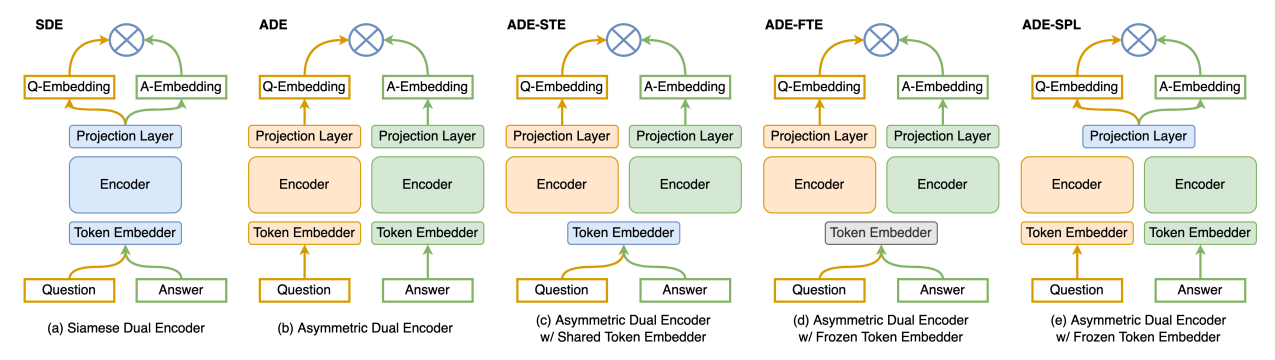

In [45]:
def get_embedding(text):
  endpoint = "https://mtknycuragwebinar.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-05-01-preview"
  api_key = "0c5f01ee8e054bf2aca7bea850d69a04"

  # 設定請求標頭
  headers = {
    "Content-Type": "application/json",
    "api-key": api_key
  }

  # 設定請求的資料
  data = {
    "input": text
  }

  # 發送 POST 請求
  response = requests.post(endpoint, headers=headers, data=json.dumps(data))

  # 檢查請求是否成功
  if response.status_code == 200:
    response_data = response.json()
    embeddings = response_data["data"][0]["embedding"]
  else:
    print("請求失敗，狀態碼：", response.status_code)
    print("錯誤訊息：", response.text)
  return embeddings


In [ ]:
question_embedding = []
context_embedding = []
for i in range(len(test)):
    question_emb = get_embedding(test.iloc[i]['question'])
    context_emb = get_embedding(test.iloc[i]['context'])
    question_embedding.append(question_emb)
    context_embedding.append(context_emb)
torch.save(torch.tensor(question_embedding), "test_question_embedding_ada.pt")
torch.save(torch.tensor(context_embedding), "test_context_embedding_ada.pt")
#cost 10 minute

# load positive/ negative data

In [52]:
data = pd.read_csv("/content/MTK_TA/qc_all.csv")

context_embedding = torch.load("/content/MTK_TA/MTK_context_embedding_ada.pt")
question_embedding = torch.load("/content/MTK_TA/MTK_question_embedding_ada.pt")
print(len(data))
print(context_embedding.shape)
print(question_embedding.shape)

2000
torch.Size([2000, 1536])
torch.Size([2000, 1536])


In [55]:
data.head()

,question,context,label
0,約12%至24%的哪種人擁有自殺的傾向?,與一般人群相比，嗜賭與日益增漲的自殺意念和企圖緊密相聯。約有12%至24%的病態賭徒有自殺的...,1
1,很多人認為在什麼時間之後韓國就不再是漢江奇蹟？,東芝是世界上晶片製造商中的重要成員。在1980年代東芝與日本電氣是世界上最大的兩家半導體製造...,0
2,哈德遜灣公司的總公司設在哪邊？,多倫多是加拿大的金融中心。多倫多證券交易所是加拿大最大的證券交易所，而加拿大五大銀行的總部皆...,1
3,用戶網適度維基的釋出經理擔任了什麼組織的技術長？,根據《梅里亞姆-韋伯斯特字典》定義，獨裁政體是一種政府形式，由一個單一個人，或一個小群體，集...,0
4,西班牙憑什麼將關島給美國？,白色是一種包含光譜中所有顏色光的顏色，通常被認為是無色的，其明度最高，色相為零。可以將光譜中...,0


Original data

In [53]:
train_x = question_embedding[:1600].squeeze(1)
train_y = context_embedding[:1600].squeeze(1)
val_x = question_embedding[1600:2000].squeeze(1)
val_y = context_embedding[1600:2000].squeeze(1)

print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)

torch.Size([1600, 1536])
torch.Size([1600, 1536])
torch.Size([400, 1536])
torch.Size([400, 1536])


In [54]:
# just a copy for training
train_x_tensor = torch.clone(train_x)
train_y_tensor = torch.clone(train_y)
val_x_tensor = torch.clone(val_x)
val_y_tensor = torch.clone(val_y)

print(train_x_tensor.shape)
print(train_y_tensor.shape)
print(val_x_tensor.shape)
print(val_y_tensor.shape)
train_label=data[:1600]['label']
val_label=data[1600:2000]['label']

label_val_tensor = torch.tensor(val_label.values)
label_train_tensor = torch.tensor(train_label.values)
print(label_train_tensor.shape)
print(label_val_tensor.shape)

torch.Size([1600, 1536])
torch.Size([1600, 1536])
torch.Size([400, 1536])
torch.Size([400, 1536])
torch.Size([1600])
torch.Size([400])


In [56]:
#train modelcode-2
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(f'DEVICE: {device}')

DEVICE: cpu


In [96]:

#train modelcode-4
from torch import optim
same_seeds(4999)
# training parameters
early_stop = 10
num_epoch =  50     # number of training epoch
BATCH_SIZE = 32
learning_rate = 1e-5  # learning rate
embedding_dim=1536
hidden_dim=768
# the path where checkpoint saved
model_path = 'MTK_SDE.pt'
# create model, define a loss function, and optimizer

SDE and ADE

In [106]:
class SDE(nn.Module):

    def __init__(self, embedding_dim, hidden_dim):
        super(SDE, self).__init__()
        self.sde1=nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_dim, embedding_dim),
            nn.Dropout(p=0.2))


    def forward(self, query, document):
        enc_query = self.sde1(query)
        enc_query = enc_query + query  #residual connection
        # Cross-Encoder approach: enc_doc = Encoder(query + document)
        enc_document = self.sde1(query+document) # query and
        enc_document = enc_document + document
        return enc_query, enc_document

In [107]:
# 0411 version

import torch.nn as nn
import torch.nn.functional as F
class DualEncoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(DualEncoder, self).__init__()
        self.dropout = nn.Dropout(p=0.2)
        self.query_encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_dim, embedding_dim),
            nn.Dropout(p=0.2))
        self.doc_encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_dim, embedding_dim),
            nn.Dropout(p=0.2)
        )
    def forward(self, query, doc):
        query_emb = self.query_encoder(query)
        query_emb=query_emb+query
        doc_emb = self.doc_encoder(query+doc)
        doc_emb=doc_emb + doc
        return query_emb, doc_emb
    def cal_loss(self, pred, label, target):
        loss1 = nn.CosineEmbeddingLoss(margin=0, reduction='mean').to(device)
        loss = loss1(pred, label, target)
        return loss

In [68]:
from numpy import dot
from numpy.linalg import norm
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=0.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = 0.0

    def forward(self, output1, output2, label):

        cos_sim = F.cosine_similarity(output1,output2)
        loss_contrastive = torch.mean((1-label)*torch.div(torch.pow((1.0-cos_sim), 2), 4)+
                                      (label)*torch.pow(cos_sim*torch.lt(cos_sim, self.margin),2))


        return loss_contrastive

In [108]:

model = SDE(embedding_dim, hidden_dim).to(device)
loss = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [109]:
#train modelcode-6
from torch.utils.data import DataLoader
train_set = torch.utils.data.TensorDataset(train_x_tensor, train_y_tensor, label_train_tensor)
val_set =  torch.utils.data.TensorDataset(val_x_tensor, val_y_tensor, label_val_tensor)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

In [110]:
from torch.nn.functional import cosine_similarity
min_loss = 1000
early_stop_count = 0

for epoch in range(num_epoch):
    train_loss = 0.0
    val_loss = 0.0
    # training
    model.train() # set the model to training mode
    for i, (train_x, train_y, label_tra) in enumerate(train_loader):
        x, y ,label=train_x, train_y, label_tra
        x, y ,label=x.to(device), y.to(device), label.to(device)
        label=label.to(device) # 1, -1
        optimizer.zero_grad()
        linear_x, linear_y = model(x, y)
        linear_x, linear_y=linear_x.to(torch.float32), linear_y.to(torch.float32)
        linear_x, linear_y=linear_x.to(device), linear_y.to(device)
        tra_batch_loss =  loss(linear_x, linear_y, label)
        tra_batch_loss.backward()
        optimizer.step()
        train_loss += tra_batch_loss.item()



   # validation
    if len(val_set) > 0:
        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for i, (val_x, val_y, label_val) in enumerate(val_loader):
                valx, valy, valabel=val_x, val_y, label_val
                valx, valy ,valabel=x.to(device), y.to(device), label.to(device)
                val_linear_x, val_linear_y = model(x, y)
                val_linear_x, val_linear_y=val_linear_x, val_linear_y
                val_linear_x, val_linear_y=val_linear_x, val_linear_y
                val_batch_loss =  loss(val_linear_x, val_linear_y, valabel)
                val_loss += val_batch_loss.item()

            print('[{:03d}/{:03d}] train_Loss: {:3.6f} |  val_loss: {:3.6f}'.format(
                epoch + 1, num_epoch, train_loss/len(train_loader), val_loss/len(val_loader)
            ))


            if val_loss < min_loss:
                    early_stop_count = 0
                    min_loss = val_loss

            else:
                    early_stop_count += 1


            if early_stop_count >= early_stop:
                print("the loss has not been lower for 10 epochs, training ceased")
                #torch.save(model.state_dict(), model_path)
                torch.save({
                'epoch': num_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                }, model_path)
                print('saving model at last epoch')
                break
    else:
        print('[{:03d}/{:03d}]  train_Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_loss/len(train_loader)
        ))

torch.save({
                'epoch': num_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                }, model_path)
print('training finish and saving model at model path')

[001/050] train_Loss: 0.007761 |  val_loss: 0.001755
[002/050] train_Loss: 0.005828 |  val_loss: 0.001325
[003/050] train_Loss: 0.004994 |  val_loss: 0.000743
[004/050] train_Loss: 0.004534 |  val_loss: 0.000667
[005/050] train_Loss: 0.004196 |  val_loss: 0.000311
[006/050] train_Loss: 0.003960 |  val_loss: 0.000703
[007/050] train_Loss: 0.003752 |  val_loss: 0.000745
[008/050] train_Loss: 0.003577 |  val_loss: 0.000541
[009/050] train_Loss: 0.003495 |  val_loss: 0.000405
[010/050] train_Loss: 0.003376 |  val_loss: 0.000450
[011/050] train_Loss: 0.003287 |  val_loss: 0.000334
[012/050] train_Loss: 0.003161 |  val_loss: 0.000476
[013/050] train_Loss: 0.003112 |  val_loss: 0.000462
[014/050] train_Loss: 0.003024 |  val_loss: 0.000569
[015/050] train_Loss: 0.002957 |  val_loss: 0.000510
the loss has not been lower for 10 epochs, training ceased
saving model at last epoch
training finish and saving model at model path


# load trained model and inference

In [111]:
#model train完而且儲存了
#接下來把model拿出來做 question to context的轉換
model_eval = SDE(embedding_dim, hidden_dim).to(device)

checkpoint = torch.load("/content/MTK_SDE.pt") # load pretrained weight

model_eval.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model_eval.eval()

SDE(
  (sde1): Sequential(
    (0): Linear(in_features=1536, out_features=768, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=768, out_features=1536, bias=True)
    (3): Dropout(p=0.2, inplace=False)
  )
)

In [112]:
test_context_embedding = torch.load("/content/MTK_TA/test_context_embedding_ada.pt")
test_question_embedding = torch.load("/content/MTK_TA/test_question_embedding_ada.pt")
print(len(test))
print(test_context_embedding.shape)
print(test_question_embedding.shape)

162
torch.Size([162, 1536])
torch.Size([162, 1536])


In [113]:
eval_q = test_question_embedding.squeeze(1)  # 輸入query
eval_c = test_context_embedding.squeeze(1)  # 輸入document
pred_x, pred_y = model_eval(eval_q.to(device).float(), eval_c.to(device).float()) # 319

In [114]:
val_cont = test
val_cont = val_cont.reset_index(drop = True)

In [115]:
from sentence_transformers import util
# Query sentences:
# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5
# Alternatively, we can also use util.semantic_search to perform cosine similarty + topk
cos_scores = util.semantic_search(pred_x, pred_y, top_k = top_k)

# answer[i][j] = the ith most similar predicted context for question_j

answer=[[] for _ in range(top_k)]
for i in range(eval_q.shape[0]):
    for j in range(top_k):
        answer[j].append(val_cont.iloc[cos_scores[i][j]["corpus_id"]])

In [116]:
top5_hit = []
top1_hit = []
for i in range(test.shape[0]):
    m = 0
    f = 0
    for j in range(top_k):
        # if the original context_i for question_i is in the top_j most similar predicted contexts, acc add 1
        if test.iloc[i]['paragraph'] == answer[j][i].paragraph:
            m = 1
        if j == 0 and test.iloc[i]['paragraph'] == answer[j][i].paragraph:
            f = 1
    top5_hit.append(m)
    top1_hit.append(f)

print(sum(top5_hit)/len(top5_hit))
print(sum(top1_hit)/len(top1_hit))

0.9691358024691358
0.8950617283950617


In [ ]:
def rag_ask(question, topk):
    data = {
    "input": question
    }
    endpoint = "https://mtknycuragwebinar.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-05-01-preview"
    api_key = userdata.get('mtk')
    headers = {
    "Content-Type": "application/json",
    "api-key": api_key
    }
    query_template = """請根據給定的文件回答問題,如果無法回答請回覆"超出可回答文件範圍"
        文件:
        \"\"\"
        {}
        \"\"\"
        問題: {}"""
    doc=vectorstore.similarity_search_with_score(question, k=topk)
    template = query_template.format(str(doc), question)
    data = {
    "messages": [
        {"role": "system", "content": "請根據給定的文件回答問題"},
        {"role": "user", "content": template}
    ],
    "max_tokens": 100,
    "temperature": 0.0
      }

    response = requests.post(endpoint, headers=headers, data=json.dumps(data))

    # 檢查請求是否成功
    if response.status_code == 200:
      response_data = response.json()
      print("問題", question)
      print("回應：", response_data["choices"][0]["message"]["content"])
    else:
      print("請求失敗，狀態碼：", response.status_code)
      print("錯誤訊息：", response.text)

https://aclanthology.org/2022.emnlp-main.640.pdf

Conclusion:
By directly probing the embedding space, we demonstrate that the shared projection layers in SDE and ADE-SPL maps the embeddings of the two encoder
towers into coinciding parameter spaces, which is
crucial for improving the retrieval quality. Therefore, we recommend to share the projection layers between two encoders of ADEs in practice.

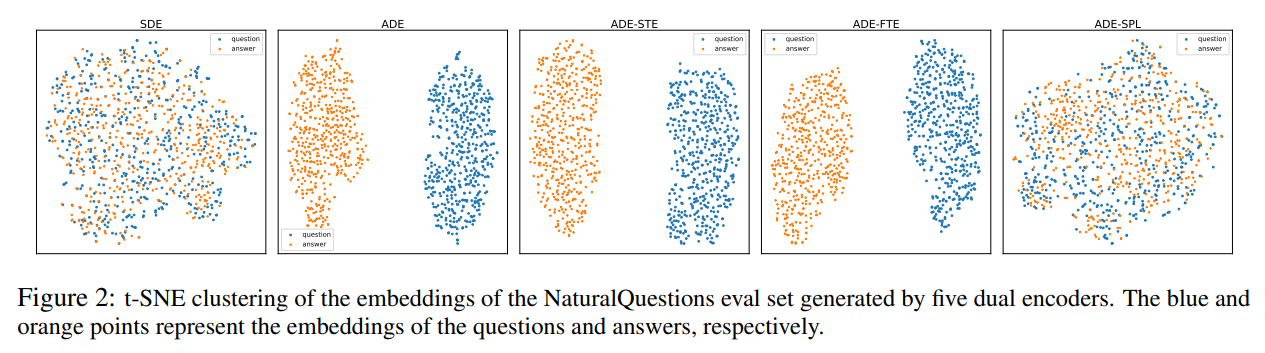